In [1]:
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [2]:
# Retrieve the data
Belem = pd.read_csv(Path() / "data" / "obs-pr" / "belem.csv")
Helsinki = pd.read_csv(Path() / "data" / "obs-pr" / "helsinki.csv")
ERA5 = xr.open_dataset(Path() / "data" / "era5-pr" / "data.nc")

In [3]:
# Extract the data variables
Time = ERA5["valid_time"].data
ERA5_PR = ERA5["tp"] * 1000
Belem_PR = Belem["PR"]
Helsinki_PR = Helsinki["PR"]

In [4]:
ERA5_PR.shape, Belem_PR.shape, Helsinki_PR.shape

((72, 721, 1440), (72,), (72,))

In [5]:
def extract_and_plot(
    ERA5_PR: xr.DataArray, Belem_PR: pd.DataFrame, Helsinki_PR: pd.DataFrame, title: str
):
    ERA5_Belem_PR = ERA5_PR.sel(
        latitude=-1.4563, longitude=360 - 48.5013, method="nearest"
    ).data
    ERA5_Helsinki_PR = ERA5_PR.sel(
        latitude=60.1699, longitude=24.9384, method="nearest"
    ).data

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    ax1.set_title(f"{title}: ERA5")
    ax2.set_title("Observations")

    pos = mdates.HourLocator(byhour=(0, 6, 12, 18))
    fmt = mdates.DateFormatter("%d-%m %Hh")

    ax1.plot(Time, ERA5_Belem_PR, label="Belem, Brazil")
    ax1.plot(Time, ERA5_Helsinki_PR, label="Helsinki, Finland")

    ax1.set_ylabel("ERA5 PR (mm)")
    ax1.xaxis.set(major_locator=pos, major_formatter=fmt)
    ax1.set_xlim(Time.min(), Time.max())
    ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=30, ha="right")

    ax2.plot(Time, Belem_PR, label="Belem, Brazil")
    ax2.plot(Time, Helsinki_PR, label="Helsinki, Finland")

    ax2.set_ylabel("OBS PR (mm)")
    ax2.xaxis.set(major_locator=pos, major_formatter=fmt)
    ax2.set_xlim(Time.min(), Time.max())
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=30, ha="right")

    plt.tight_layout()

    ax2.legend()

    plt.show()

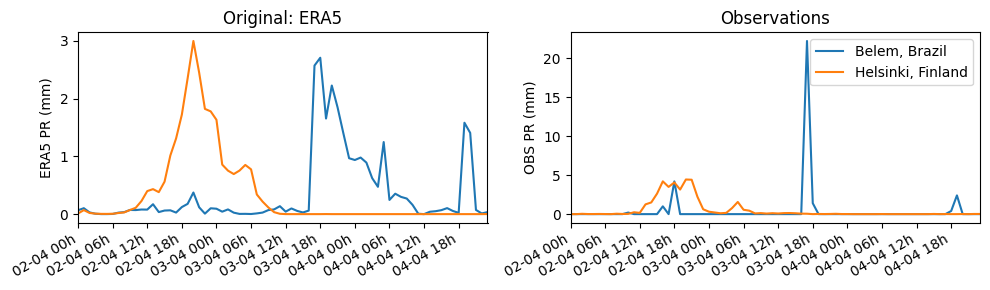

In [6]:
extract_and_plot(ERA5_PR, Belem_PR, Helsinki_PR, "Original")

In [7]:
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_zfp import Zfp

In [8]:
def encode_decode(codec):
    ERA5_PR_codec = ERA5_PR.copy(data=codec.decode(codec.encode(ERA5_PR.values)))

    Belem_PR_codec = Belem_PR.copy(deep=True)
    Belem_PR_codec.values[:] = codec.decode(codec.encode(Belem_PR_codec.values))

    Helsinki_PR_codec = Helsinki_PR.copy(deep=True)
    Helsinki_PR_codec.values[:] = codec.decode(codec.encode(Helsinki_PR_codec.values))

    return ERA5_PR_codec, Belem_PR_codec, Helsinki_PR_codec

In [9]:
sperr = Sperr(mode="pwe", pwe=0.1)
ERA5_PR_sperr, Belem_PR_sperr, Helsinki_PR_sperr = encode_decode(sperr)
del sperr

In [10]:
sz3 = Sz3(eb_mode="abs", eb_abs=0.1)
ERA5_PR_sz3, Belem_PR_sz3, Helsinki_PR_sz3 = encode_decode(sz3)
del sz3

In [11]:
zfp = Zfp(mode="fixed-accuracy", tolerance=0.1)
ERA5_PR_zfp, Belem_PR_zfp, Helsinki_PR_zfp = encode_decode(zfp)
del zfp

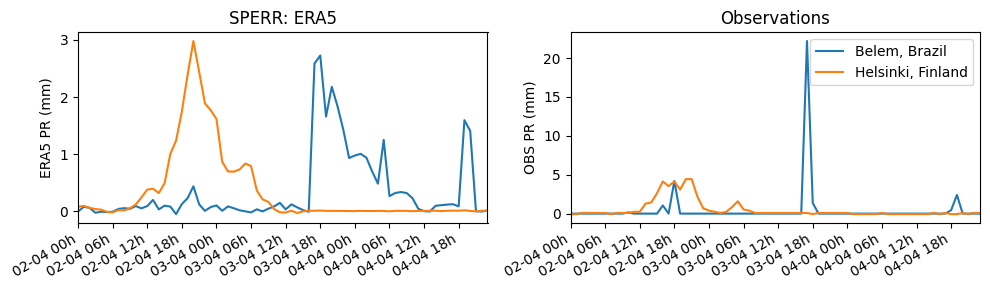

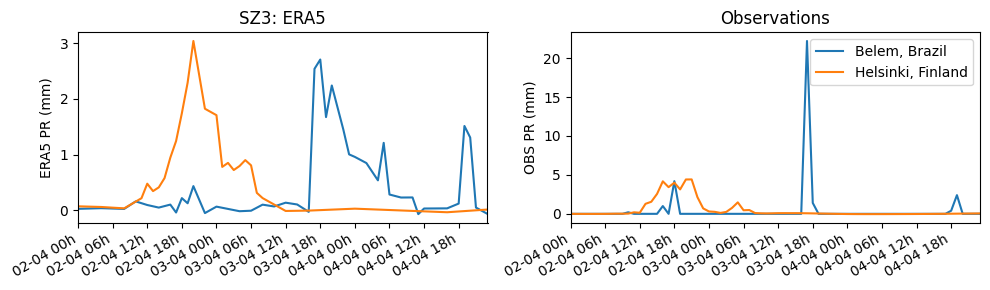

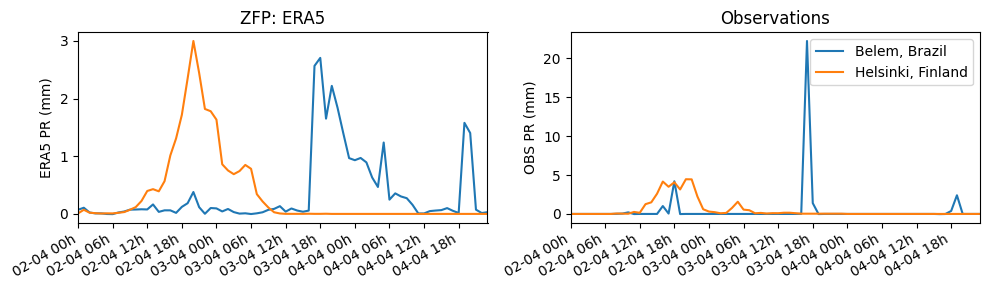

In [12]:
extract_and_plot(ERA5_PR_sperr, Belem_PR_sperr, Helsinki_PR_sperr, "SPERR")
extract_and_plot(ERA5_PR_sz3, Belem_PR_sz3, Helsinki_PR_sz3, "SZ3")
extract_and_plot(ERA5_PR_zfp, Belem_PR_zfp, Helsinki_PR_zfp, "ZFP")